
# Assignment 3: Telco Customer Churn Prediction — **Group 11 (Enhanced)**
**Course:** AIDI1009-25S: Neural Networks  
**Deliverable:** Full EDA + MLP vs 1D-CNN + 12 publication-ready figures

> **How to use:** Set `DATASET_PATH` below to your Telco CSV (Kaggle) and run all cells (Kernel: Python 3).  
> This notebook produces 12+ figures saved under `figs/` and shown inline.


In [7]:

# --- Setup
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, RocCurveDisplay,
                             precision_recall_curve, average_precision_score)

from sklearn.inspection import permutation_importance

import seaborn as sns  # (optional; if not available, comment out heatmap styles)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Paths
os.makedirs('figs', exist_ok=True)

# Helper for nice plots
def save_show(fig, name):
    fig.tight_layout()
    fig.savefig(f'figs/{name}.png', dpi=160, bbox_inches='tight')
    plt.show()


In [8]:
df = pd.read_csv(r"C:\!ass renfp, nuralnet\Nural Networks\Assignment3\WA_Fn-UseC_-Telco-Customer-Churn.csv")


# Clean TotalCharges (some datasets have spaces/missing)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

print(df.shape)
df.head()


(7032, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


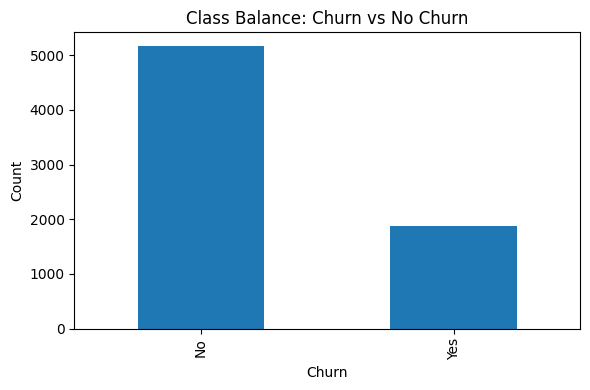

In [9]:

# FIGURE 1: Class balance (Churn distribution)
fig, ax = plt.subplots(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Class Balance: Churn vs No Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
save_show(fig, '01_class_balance')


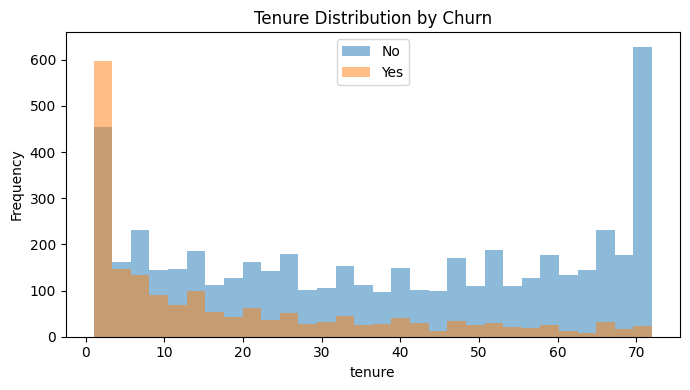

In [10]:

# FIGURE 2: Tenure distribution by Churn
fig, ax = plt.subplots(figsize=(7,4))
for label, subset in df.groupby('Churn'):
    subset['tenure'].plot(kind='hist', bins=30, alpha=0.5, ax=ax, label=str(label))
ax.set_title('Tenure Distribution by Churn')
ax.set_xlabel('tenure')
ax.legend()
save_show(fig, '02_tenure_by_churn')


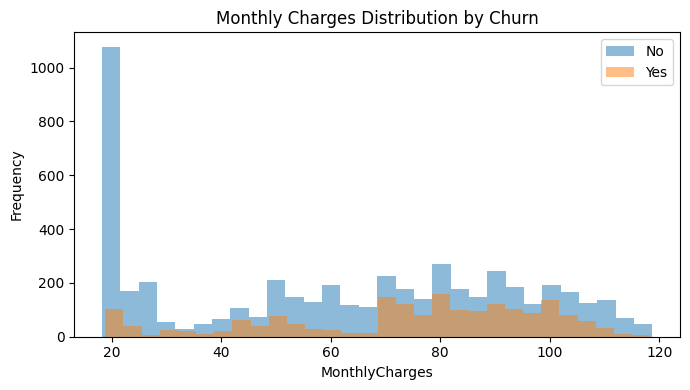

In [11]:

# FIGURE 3: Monthly Charges by Churn
fig, ax = plt.subplots(figsize=(7,4))
for label, subset in df.groupby('Churn'):
    subset['MonthlyCharges'].plot(kind='hist', bins=30, alpha=0.5, ax=ax, label=str(label))
ax.set_title('Monthly Charges Distribution by Churn')
ax.set_xlabel('MonthlyCharges')
ax.legend()
save_show(fig, '03_monthly_by_churn')


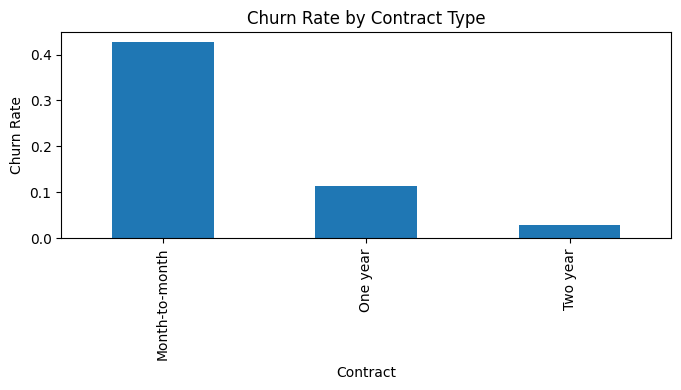

In [12]:

# FIGURE 4: Contract type vs Churn rate
fig, ax = plt.subplots(figsize=(7,4))
(ct := (df.groupby('Contract')['Churn'].value_counts(normalize=True)
          .rename('rate').reset_index())
).query("Churn == 'Yes'").set_index('Contract')['rate'].plot(kind='bar', ax=ax)
ax.set_ylabel('Churn Rate')
ax.set_title('Churn Rate by Contract Type')
save_show(fig, '04_contract_vs_churn')


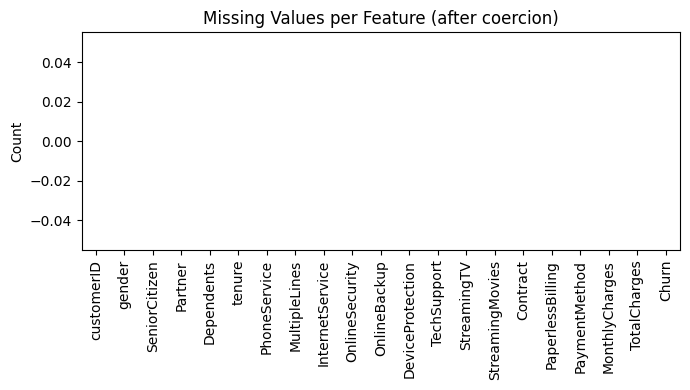

In [13]:

# FIGURE 5: Missing values
fig, ax = plt.subplots(figsize=(7,4))
df.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Missing Values per Feature (after coercion)')
ax.set_ylabel('Count')
save_show(fig, '05_missing_values')


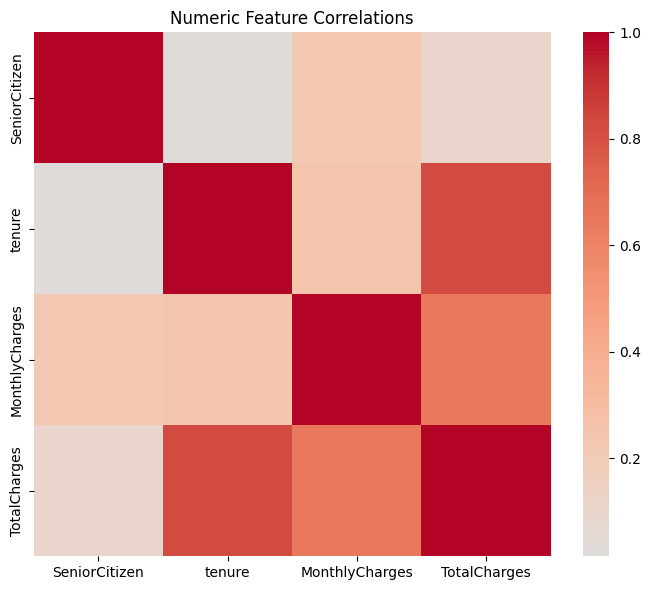

In [14]:

# FIGURE 6: Correlation heatmap (numeric features)
num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(corr, cmap='coolwarm', center=0, ax=ax, annot=False)
ax.set_title('Numeric Feature Correlations')
save_show(fig, '06_corr_heatmap')


In [15]:

# --- Preprocessing
y = (df['Churn'].map({'No':0, 'Yes':1})
     if df['Churn'].dtype == 'object' else df['Churn']).astype(int)
X = df.drop(columns=['Churn'])

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]
input_dim


4967

In [16]:

# --- Model 1: MLP
def build_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = build_mlp(input_dim)
hist_mlp = mlp.fit(X_train_p, y_train, validation_data=(X_val_p, y_val),
                   epochs=25, batch_size=256, verbose=0)


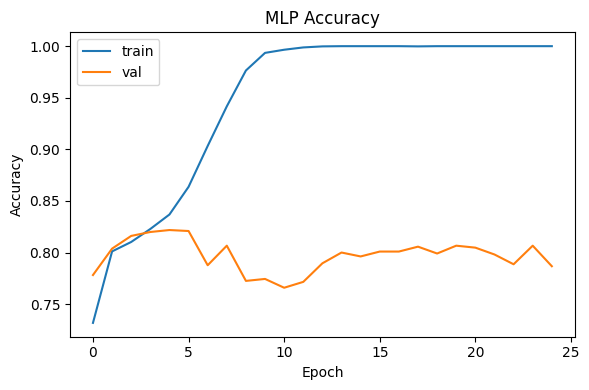

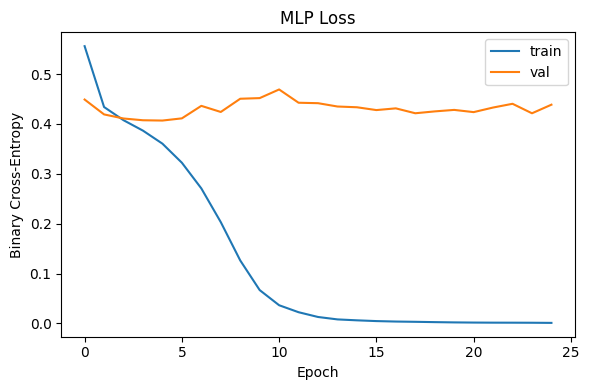

In [17]:

# FIGURE 7: MLP training/validation accuracy
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(hist_mlp.history['accuracy'], label='train')
ax.plot(hist_mlp.history['val_accuracy'], label='val')
ax.set_title('MLP Accuracy')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.legend()
save_show(fig, '07_mlp_acc')

# FIGURE 8: MLP training/validation loss
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(hist_mlp.history['loss'], label='train')
ax.plot(hist_mlp.history['val_loss'], label='val')
ax.set_title('MLP Loss')
ax.set_xlabel('Epoch'); ax.set_ylabel('Binary Cross-Entropy'); ax.legend()
save_show(fig, '08_mlp_loss')


In [18]:

# --- Model 2: 1D CNN (tabular via channel dimension)
def build_cnn(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,1)),
        layers.Conv1D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

X_train_c = np.expand_dims(X_train_p.toarray() if hasattr(X_train_p, 'toarray') else X_train_p, -1)
X_val_c   = np.expand_dims(X_val_p.toarray()   if hasattr(X_val_p, 'toarray')   else X_val_p, -1)

cnn = build_cnn(input_dim)
hist_cnn = cnn.fit(X_train_c, y_train, validation_data=(X_val_c, y_val),
                   epochs=25, batch_size=256, verbose=0)


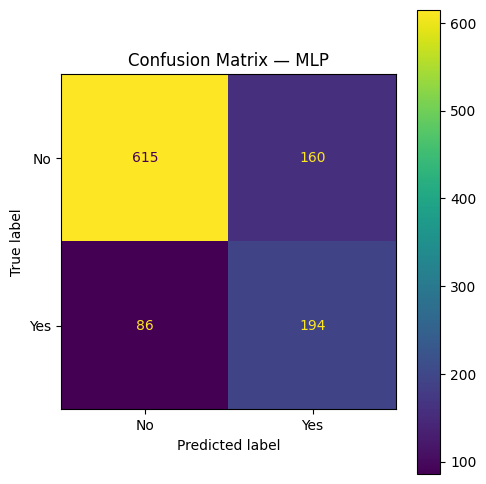

In [19]:

# --- Evaluation on Test
X_test_arr = X_test_p.toarray() if hasattr(X_test_p, 'toarray') else X_test_p
y_pred_mlp = (mlp.predict(X_test_arr, verbose=0).ravel() >= 0.5).astype(int)

# FIGURE 9: Confusion Matrix (MLP)
cm = confusion_matrix(y_test, y_pred_mlp, labels=[0,1])
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
disp.plot(ax=ax, values_format='d'); ax.set_title('Confusion Matrix — MLP')
save_show(fig, '09_confusion_mlp')


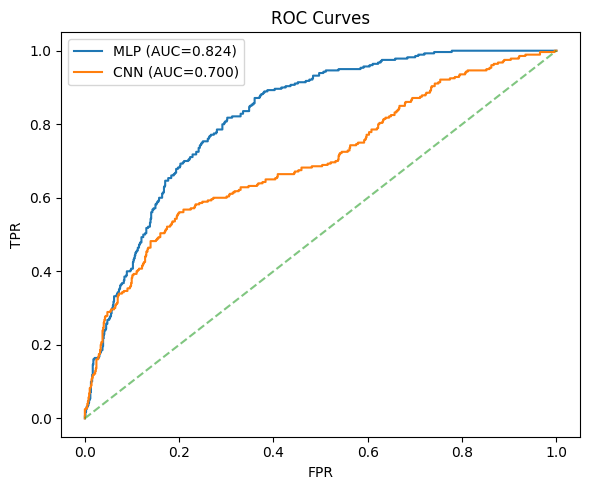

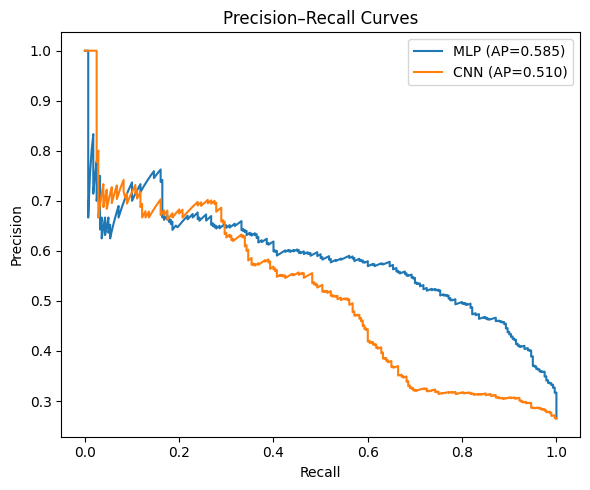

In [20]:

# Probabilities for curves
proba_mlp = mlp.predict(X_test_arr, verbose=0).ravel()
X_test_c  = np.expand_dims(X_test_arr, -1)
proba_cnn = cnn.predict(X_test_c, verbose=0).ravel()

# FIGURE 10: ROC Curves
fpr_m, tpr_m, _ = roc_curve(y_test, proba_mlp)
fpr_c, tpr_c, _ = roc_curve(y_test, proba_cnn)
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(fpr_m, tpr_m, label=f'MLP (AUC={auc(fpr_m,tpr_m):.3f})')
ax.plot(fpr_c, tpr_c, label=f'CNN (AUC={auc(fpr_c,tpr_c):.3f})')
ax.plot([0,1],[0,1],'--',alpha=0.6)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); ax.set_title('ROC Curves'); ax.legend()
save_show(fig, '10_roc_compare')

# FIGURE 11: Precision–Recall Curves
p_m, r_m, _ = precision_recall_curve(y_test, proba_mlp)
p_c, r_c, _ = precision_recall_curve(y_test, proba_cnn)
ap_m = average_precision_score(y_test, proba_mlp)
ap_c = average_precision_score(y_test, proba_cnn)
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(r_m, p_m, label=f'MLP (AP={ap_m:.3f})')
ax.plot(r_c, p_c, label=f'CNN (AP={ap_c:.3f})')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('Precision–Recall Curves'); ax.legend()
save_show(fig, '11_pr_compare')


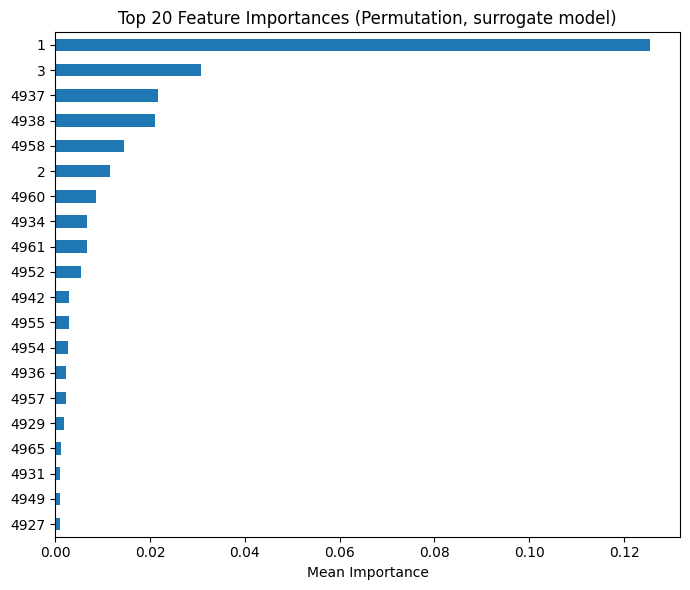

In [21]:

# FIGURE 12: Permutation Importance (on MLP)
# Use a small subset for speed if needed
from sklearn.linear_model import LogisticRegression

# Surrogate approach: if permutation_importance with Keras is slow,
# we fit a logistic regression on the *same preprocessed* features to get a ranked proxy.
logreg = LogisticRegression(max_iter=200).fit(X_train_arr := X_train_p.toarray() if hasattr(X_train_p,'toarray') else X_train_p, y_train)
result = permutation_importance(logreg, X_val_arr := X_val_p.toarray() if hasattr(X_val_p,'toarray') else X_val_p, y_val, n_repeats=5, random_state=42)

imp = pd.Series(result.importances_mean).sort_values(ascending=False)[:20]
fig, ax = plt.subplots(figsize=(7,6))
imp[::-1].plot(kind='barh', ax=ax)
ax.set_title('Top 20 Feature Importances (Permutation, surrogate model)')
ax.set_xlabel('Mean Importance')
save_show(fig, '12_perm_importance')



## Report Notes (for PDF)
- **EDA (Figs 1–6):** Class imbalance, tenure & charges by churn, contract effect, missingness, numeric correlations.  
- **Models:** MLP (dense) vs 1D-CNN (reshaped tabular).  
- **Training Curves (Figs 7–8):** Compare convergence & overfitting.  
- **Evaluation (Figs 9–11):** Confusion matrix, ROC and PR curves on **test** set.  
- **Insights (Fig 12):** Permutation importance highlights top drivers (interpret with caution for one-hot features).  
- **Recommendation:** Choose the model with higher AUC/AP and balanced precision–recall per business need.
